# The notebook contains
### Code for _Bulyan_ aggregation algorithm
### Evaluation of our SOTA AGR-tailored attack on Bulyan

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\Christy\AppData\Local\Temp\ipykernel_12120\912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math, json
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp

sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from femnist_normal_train import *
from femnist_util import *
from adam import Adam
from sgd import SGD
import torchvision.transforms as transforms
import torchvision.datasets as datasets

C:\Users\Christy\AppData\Local\Temp\ipykernel_12120\3911109398.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Get Cifar 10 non-iid data

## Our Aggregation Function

In [ ]:
def our_mean_defense(all_updates, n_attackers, history_updates):
    # update the history records
    if not history_updates:
       history_updates = [[] for _ in range(n_attackers)]
    updates_abs_mean = all_updates.abs().mean(dim=1, keepdim=True)
    for i in range(n_attackers):
        history_updates[i].extend(updates_abs_mean[i])

    discarded_history = []
    for _ in range(n_attackers):
        sum_of_distances = []
        for i, row in enumerate(history_updates):
            if i in discarded_history:
                sum_of_distances.append(-1)
                continue
            distance_sum = 0
            for j, other_row in enumerate(history_updates): 
                if row != other_row and j not in discarded_history: 
                    distance_sum += euclidean_distance(row, other_row)
            sum_of_distances.append(distance_sum)
        max_distance = max(sum_of_distances) 
        index_of_max_distance = sum_of_distances.index(max_distance)
        discarded_history.append(index_of_max_distance)
    
    # get tensors in all_updates excluding the discarded ones
    mask = torch.ones(all_updates.size(0), dtype=torch.bool)  # Create a mask of ones (True)
    mask[discarded_history] = False  # Set indices in discarded_history to False
    remaining_updates = all_updates[mask]

    # returns the mean of selected updates 
    return remaining_updates.mean(dim=0)
    

def euclidean_distance(row1, row2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(row1, row2)))


## Our attack

In [ ]:
def our_attack_mean_std(all_updates, n_attacker, criterion, user_tr_data_tensors, user_tr_label_tensors):
    
    all_updates_deviation = all_updates.std(dim=1, keepdim=True) # [50, 1]
    benign_std_avg = all_updates_deviation.mean() # [1, 1]

    all_updates_abs_mean = all_updates.abs().mean(dim=1, keepdim=True)  # [50,1]
    benign_abs_mean_avg = all_updates_abs_mean.mean() # [1, 1]

    result_attacker_grads = [] 
    # print(type(n_attacker))
    attacker_grads = all_updates[:n_attacker]


    for index, attacker_grad in enumerate(attacker_grads):

        attacker_tr_data_tensor = user_tr_data_tensors[index].cuda()
        attacker_tr_label_tensor = user_tr_label_tensors[index].cuda()

        def rosen(X):
            X = X.cuda()
            attacker_abs_mean = X.abs().mean()
            attacker_std = X.abs().std()

        #     # Reshape X into the shape of fed_model.parameters
            fed_model = mnist_conv().cuda()
            optimizer_fed = SGD(fed_model.parameters(), lr=0.5)

            optimizer_fed.zero_grad()
            model_grads=[]
            start_idx = 0
            for i, param in enumerate(fed_model.parameters()):
                param_=X[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
                start_idx=start_idx+len(param.data.view(-1))
                param_=param_.cuda()
                model_grads.append(param_)
            optimizer_fed.step(model_grads)

            return -criterion(fed_model(attacker_tr_data_tensor), attacker_tr_label_tensor) + torch.abs(benign_std_avg - attacker_abs_mean) + torch.abs(benign_abs_mean_avg - attacker_std)
        
        from torchmin import minimize

        res = minimize(
            rosen, attacker_grad, 
            method='l-bfgs', 
            options=dict(line_search='strong-wolfe'),
            max_iter=100,
            disp=False
        )
        result_attacker_grads.append(res.grad)
    return torch.stack(result_attacker_grads).cuda()

## Shejwallwar attack, 20% attacker

In [13]:
resume=0
nepochs=500
gamma=.1
fed_lr=0.001

criterion = nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()
batch_size = 100
schedule = [2000]

aggregation = 'bulyan'
at_type = 'our-agr'
chkpt = './' + aggregation
epoch_num = 0

at_fractions = [20]

for at_fraction in at_fractions:

    fed_model = mnist_conv().cuda()
    fed_model.apply(weights_init)
    optimizer_fed = Adam(fed_model.parameters(), lr=fed_lr)

    print('==> Initializing global model')
    epoch_num = 0
    best_global_acc=0
    best_global_te_acc=0

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])
    while epoch_num <= nepochs:
        user_grads = []
        
        round_users = np.random.choice(3400, 60)
        n_attacker = np.sum(round_users < (34*at_fraction))

        while  n_attacker < 2 or n_attacker > 14:
            round_users = np.random.choice(3400, 60)
            n_attacker = np.sum(round_users < (34*at_fraction))

        benign_user_index = [i for i, x in enumerate(round_users) if x > (34*at_fraction)]
        print('n_attacker is ', n_attacker)
                
        for i in round_users:

            inputs = user_tr_data_tensors[i]
            targets = user_tr_label_tensors[i]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            optimizer_fed.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None,:] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]),0)    

        malicious_grads = user_grads
        print("malicious_grads before n_attacker", malicious_grads.shape)

        if n_attacker > 0:
            agg_grads = torch.mean(malicious_grads, 0)
            mal_update = our_attack_mkrum(malicious_grads, agg_grads, n_attacker, dev_type='sign')
            mal_updates = torch.stack([mal_update] * n_attacker)

            print("mal_updates shape: ", mal_updates.shape)

            indices_tensor = torch.tensor(benign_user_index, dtype=torch.long)
            benign_user_grads = user_grads[indices_tensor]
            malicious_grads = torch.cat((mal_updates, benign_user_grads), 0)    
        
        print("malicious_grads after n_attacker", malicious_grads.shape)

        if epoch_num == 0: print('malicious grads shape ', malicious_grads.shape)

        if aggregation == 'mean':
            agg_grads=torch.mean(malicious_grads,dim=0)
            
        elif aggregation=='krum' or aggregation=='mkrum':
            multi_k = True if aggregation == 'mkrum' else False
            if epoch_num == 0: print('multi krum is ', multi_k)
            agg_grads, krum_candidate = multi_krum(malicious_grads, n_attacker, multi_k=multi_k)

        elif aggregation == 'bulyan':
            agg_grads, krum_candidate = bulyan(malicious_grads, n_attacker)
            
        start_idx=0

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)       
        
        df.to_csv('./attack_femnist.csv', index=False)

        epoch_num+=1

==> Initializing global model
n_attacker is  14
malicious_grads before n_attacker torch.Size([60, 848382])


In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("shejwallwar_has_attack_20%_attacker_"+col)
    plt.savefig('./shejwallwar_attack_femnist_20_percent_attacker' + col + '.png')
    plt.show()

## Shejwallwar attack, 2 attacker each round

In [ ]:
resume=0
nepochs=500
gamma=.1
fed_lr=0.001

criterion = nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()
batch_size = 100
schedule = [2000]

aggregation = 'bulyan'
at_type = 'our-agr'
chkpt = './' + aggregation
epoch_num = 0

at_fractions = [0]
n_attacker = 0 

for at_fraction in at_fractions:

    fed_model = mnist_conv().cuda()
    fed_model.apply(weights_init)
    optimizer_fed = Adam(fed_model.parameters(), lr=fed_lr)

    print('==> Initializing global model')
    epoch_num = 0
    best_global_acc=0
    best_global_te_acc=0

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    while epoch_num <= nepochs:
        user_grads = []
        
        round_users = np.random.choice(3400, 60)
        
        for i in round_users:

            inputs = user_tr_data_tensors[i]
            targets = user_tr_label_tensors[i]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            optimizer_fed.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None,:] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]),0)    

        malicious_grads = user_grads

        if epoch_num == 0: print('malicious grads shape ', malicious_grads.shape)

        if aggregation == 'mean':
            agg_grads=torch.mean(malicious_grads,dim=0)
            
        elif aggregation=='krum' or aggregation=='mkrum':
            multi_k = True if aggregation == 'mkrum' else False
            if epoch_num == 0: print('multi krum is ', multi_k)
            agg_grads, krum_candidate = multi_krum(malicious_grads, n_attacker, multi_k=multi_k)

        elif aggregation == 'bulyan':
            agg_grads, krum_candidate = bulyan(malicious_grads, n_attacker)
            
        start_idx=0

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        print('epoch: %d, %s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)       
        
        df.to_csv('./no_attack_femnist.csv', index=False)
        epoch_num+=1

## Our attacker 20% attacker

In [ ]:
resume=0
nepochs=500
gamma=.1
fed_lr=0.001

criterion = nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()
batch_size = 100
schedule = [2000]

aggregation = 'bulyan'
at_type = 'our-agr'
chkpt = './' + aggregation
epoch_num = 0

at_fractions = [20]

for at_fraction in at_fractions:

    fed_model = mnist_conv().cuda()
    fed_model.apply(weights_init)
    optimizer_fed = Adam(fed_model.parameters(), lr=fed_lr)

    print('==> Initializing global model')
    epoch_num = 0
    best_global_acc=0
    best_global_te_acc=0

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])
    while epoch_num <= nepochs:
        user_grads = []
        
        round_users = np.random.choice(3400, 60)
        n_attacker = np.sum(round_users < (34*at_fraction))

        while  n_attacker < 2 or n_attacker > 14:
            round_users = np.random.choice(3400, 60)
            n_attacker = np.sum(round_users < (34*at_fraction))

        benign_user_index = [i for i, x in enumerate(round_users) if x > (34*at_fraction)]
        print('n_attacker is ', n_attacker)
                
        for i in round_users:

            inputs = user_tr_data_tensors[i]
            targets = user_tr_label_tensors[i]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            optimizer_fed.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None,:] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]),0)    

        malicious_grads = user_grads
        # print("malicious_grads before n_attacker", malicious_grads.shape)

        if n_attacker > 0:

            mal_updates = our_attack_mean_std(user_grads, n_attacker, criterion, user_tr_data_tensors, user_tr_label_tensors)

            indices_tensor = torch.tensor(benign_user_index, dtype=torch.long)
            benign_user_grads = user_grads[indices_tensor]
            malicious_grads = torch.cat((mal_updates, benign_user_grads), 0)    
        
        # print("malicious_grads after n_attacker", malicious_grads.shape)

        if epoch_num == 0: print('malicious grads shape ', malicious_grads.shape)

        if aggregation == 'mean':
            agg_grads=torch.mean(malicious_grads,dim=0)
            
        elif aggregation=='krum' or aggregation=='mkrum':
            multi_k = True if aggregation == 'mkrum' else False
            if epoch_num == 0: print('multi krum is ', multi_k)
            agg_grads, krum_candidate = multi_krum(malicious_grads, n_attacker, multi_k=multi_k)

        elif aggregation == 'bulyan':
            agg_grads, krum_candidate = bulyan(malicious_grads, n_attacker)
            
        start_idx=0

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)       
        
        df.to_csv('./attack_femnist.csv', index=False)

        epoch_num+=1

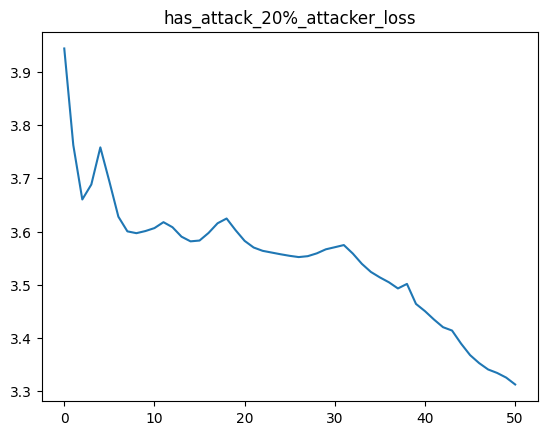

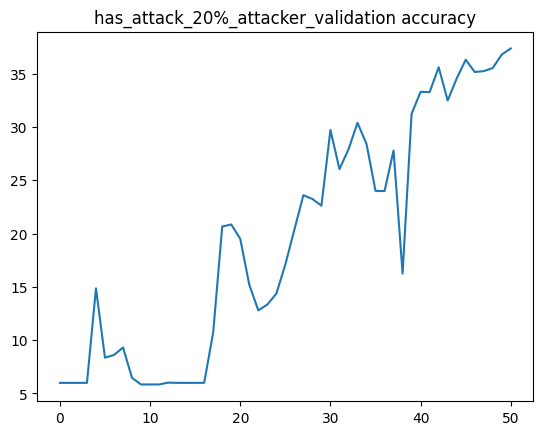

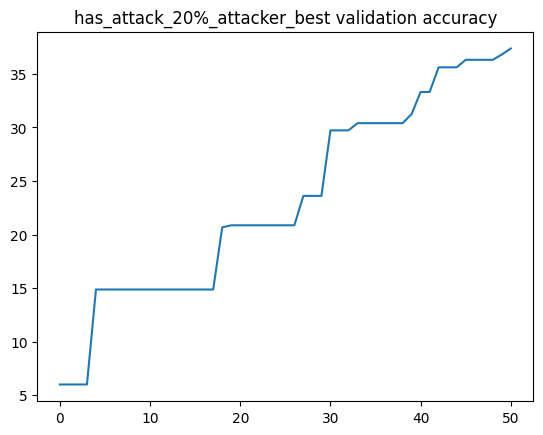

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("has_attack_20%_attacker_"+col)
    plt.savefig('./attack_femnist_20_percent_attacker' + col + '.png')
    plt.show()

## Our attack, 2 attacker each round

In [12]:
resume=0
nepochs=500
gamma=.1
fed_lr=0.001

criterion = nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()
batch_size = 100
schedule = [2000]

aggregation = 'bulyan'
at_type = 'our-agr'
chkpt = './' + aggregation
epoch_num = 0

at_fractions = [0]
n_attacker = 0 

for at_fraction in at_fractions:

    fed_model = mnist_conv().cuda()
    fed_model.apply(weights_init)
    optimizer_fed = Adam(fed_model.parameters(), lr=fed_lr)

    print('==> Initializing global model')
    epoch_num = 0
    best_global_acc=0
    best_global_te_acc=0

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    while epoch_num <= nepochs:
        user_grads = []
        
        round_users = np.random.choice(3400, 60)
        
        for i in round_users:

            inputs = user_tr_data_tensors[i]
            targets = user_tr_label_tensors[i]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            optimizer_fed.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None,:] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]),0)    

        malicious_grads = user_grads

        if epoch_num == 0: print('malicious grads shape ', malicious_grads.shape)

        if aggregation == 'mean':
            agg_grads=torch.mean(malicious_grads,dim=0)
            
        elif aggregation=='krum' or aggregation=='mkrum':
            multi_k = True if aggregation == 'mkrum' else False
            if epoch_num == 0: print('multi krum is ', multi_k)
            agg_grads, krum_candidate = multi_krum(malicious_grads, n_attacker, multi_k=multi_k)

        elif aggregation == 'bulyan':
            agg_grads, krum_candidate = bulyan(malicious_grads, n_attacker)
            
        start_idx=0

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        print('epoch: %d, %s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)       
        
        df.to_csv('./no_attack_femnist.csv', index=False)
        epoch_num+=1

==> Initializing global model
malicious grads shape  torch.Size([60, 848382])
epoch: 0, bulyan: at our-agr n_at 0 n_mal_sel 0 e 0 | val loss 3.9262 val acc 5.8388 best val_acc 5.838816


C:\Users\Hizan\AppData\Local\Temp\ipykernel_1804\1874802907.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


epoch: 1, bulyan: at our-agr n_at 0 n_mal_sel 0 e 1 | val loss 3.7485 val acc 5.8388 best val_acc 5.838816
epoch: 2, bulyan: at our-agr n_at 0 n_mal_sel 0 e 2 | val loss 3.6495 val acc 5.8388 best val_acc 5.838816
epoch: 3, bulyan: at our-agr n_at 0 n_mal_sel 0 e 3 | val loss 3.6401 val acc 9.2311 best val_acc 9.231086
epoch: 4, bulyan: at our-agr n_at 0 n_mal_sel 0 e 4 | val loss 3.6154 val acc 6.1986 best val_acc 9.231086
epoch: 5, bulyan: at our-agr n_at 0 n_mal_sel 0 e 5 | val loss 3.5937 val acc 6.1986 best val_acc 9.231086
epoch: 6, bulyan: at our-agr n_at 0 n_mal_sel 0 e 6 | val loss 3.5964 val acc 5.4996 best val_acc 9.231086
epoch: 7, bulyan: at our-agr n_at 0 n_mal_sel 0 e 7 | val loss 3.6154 val acc 5.4893 best val_acc 9.231086
epoch: 8, bulyan: at our-agr n_at 0 n_mal_sel 0 e 8 | val loss 3.6226 val acc 11.5723 best val_acc 11.572266
epoch: 9, bulyan: at our-agr n_at 0 n_mal_sel 0 e 9 | val loss 3.6095 val acc 6.9233 best val_acc 11.572266
epoch: 10, bulyan: at our-agr n_at

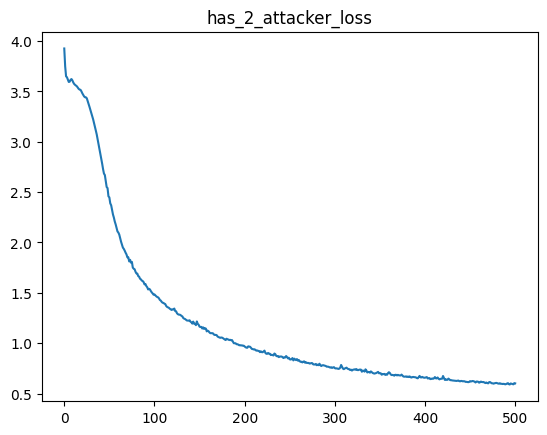

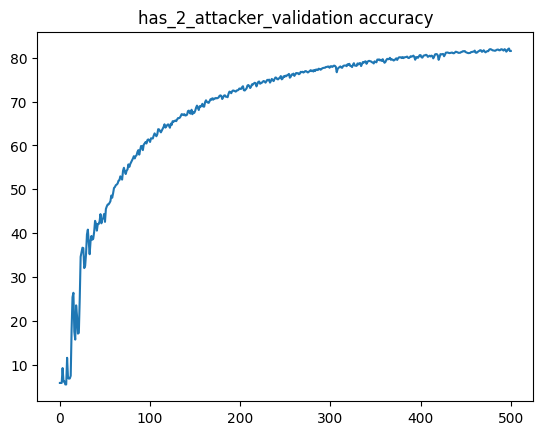

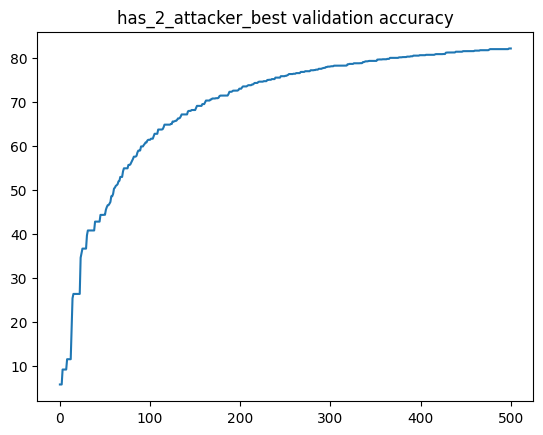

In [13]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("has_2_attacker_"+col)
    plt.savefig('./no_attack_FEMNIST_' + col + '.png')
    plt.show()